# Exploring relationships among categorical variables

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'educ_num',
        'marital_status', 'occupation', 'relationship', 'race',
        'sex', 'capgain', 'caploss', 'hours', 'country',
        'income']
df = pd.read_csv('../../data/adult.data', names=cols)

In [4]:
df.shape

(32561, 15)

In [5]:
df['sex'] = df['sex'].str.strip()
df['relationship'] = df['relationship'].str.strip()
df['income'] = df['income'].str.strip()

In [6]:
df.sample(3)

,age,workclass,fnlwgt,education,educ_num,marital_status,occupation,relationship,race,sex,capgain,caploss,hours,country,income
20384,35,Private,219902,Assoc-voc,11,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,40,United-States,<=50K
20502,52,Private,177366,HS-grad,9,Separated,Other-service,Other-relative,White,Female,0,0,20,United-States,<=50K
5399,32,Private,53260,HS-grad,9,Divorced,Other-service,Unmarried,Other,Female,0,0,28,United-States,<=50K


## Multivariate analysis: categorical vs. categorical

### Two-way table

Two-way frequency tables, also called contingency tables or confusion matrices, are tables of counts with two dimensions where each dimension is a different variable. Two-way tables can give you insight into the relationship between two variables.

In [7]:
twowayct = pd.crosstab(index=df['relationship'], columns=df['sex'], margins=False)
twowayct

sex,Female,Male
relationship,,
Husband,1,13192
Not-in-family,3875,4430
Other-relative,430,551
Own-child,2245,2823
Unmarried,2654,792
Wife,1566,2


### Histograms by category
Side by side histograms let you compare the distributions of an attribute by category.

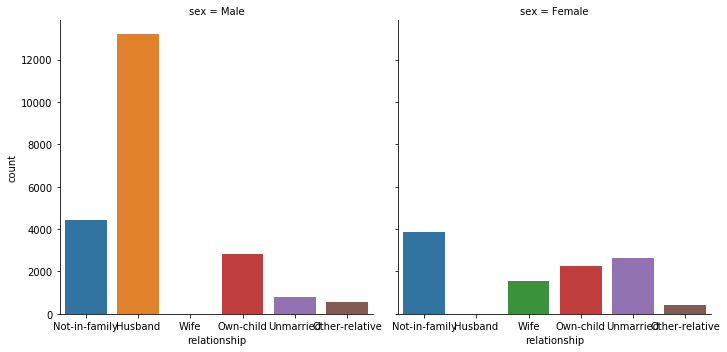

In [8]:
sns.catplot(data=df, x='relationship', col='sex', kind='count')

Stacked bars/histograms are painful in Python, but can be done. (Consider ggplot.)

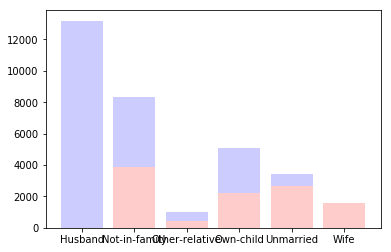

In [9]:
plt.bar(twowayct.index.values, twowayct.Female.values, color='#ffcccc')
plt.bar(twowayct.index.values, twowayct.Male.values, color='#ccccff', bottom=twowayct.Female.values)
plt.show()

### $\chi^{2}$ test for independence

We can use the $\chi^{2}$ test to determine whether an association (or relationship) between two categorical variables is significant. (Note: this test will not give us a sense of the size/strength or direction of the relationship.)

* p=0 = dependent
* p=1 = independent
* p=0.05 = significant relationship at 95% confidence level

In [63]:
row_totals = twowayct.agg(sum, axis=1).values
col_totals = twowayct.agg(sum, axis=0).values

In [64]:
row_totals, col_totals

(array([13193,  8305,   981,  5068,  3446,  1568]), array([10771, 21790]))

In [66]:
twowayct.columns.values

array(['Female', 'Male'], dtype=object)

In [67]:
# Compute the expected values
N = sum(row_totals) # or sum(col_totals) -- total number of records
expected =  np.outer(row_totals, col_totals) / N
expected = pd.DataFrame(expected)
expected.columns = twowayct.columns.values
expected.index = twowayct.index.values
expected

,Female,Male
Husband,4364.171954,8828.828046
Not-in-family,2747.248395,5557.751605
Other-relative,324.509413,656.490587
Own-child,1676.466570,3391.533430
Unmarried,1139.917877,2306.082123
Wife,518.685790,1049.314210


In [10]:
from scipy.stats import chisquare

In [91]:
c, p = chisquare(twowayct, expected)

In [94]:
c, p

(array([9177.97931491, 4536.76067925]), array([0., 0.]))

The p-value of 0 suggests there is strong evidence against the null hypothesis (that the categorical data has the expected frequencies). That is to say, the observed data are not independent. Thus, we may conclude that there is a relationship between the 'sex' and 'relationship' attributes.

The nature and scale of this relationship is not known at this point.

Since the p-value is very small, the two lists of values are NOT independent. That is, it appears that
there is a significant linear relationship between relationship and sex.

If we want to understand the effect SIZE, we could apply Cramér's V. (Do not try this at home.)

## Multivariate analysis: categorical vs. continuous

### Box plots (or similar) by category

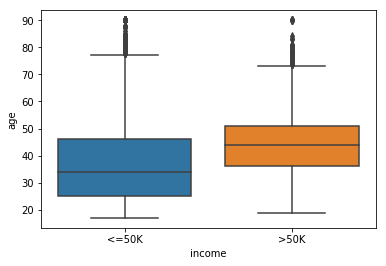

In [95]:
sns.boxplot(x=df['income'], y=df['age'])

### Difference of means (binary categorical)
Calculate the T-test for the means of two independent samples.

In [96]:
from scipy.stats import ttest_ind

In [97]:
ttest_ind(df[df['income']=='<=50K']['age'], df[df['income']=='>50K']['age'])

Ttest_indResult(statistic=-43.436244240451096, pvalue=0.0)

I appears that our p-value is very small, so we reject the null hypothesis of equal means.

According to this test, these two groups represent different populations. In other words,
the age distributions among people in the higher income differs meaningfully from that of the lower income group.

This should not come as a shock, but if you're still not convinced let's look at violin plots:

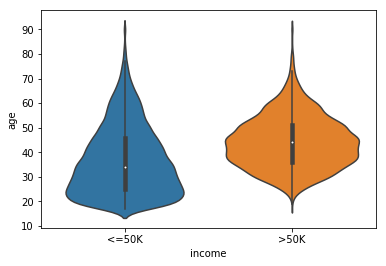

In [98]:
sns.violinplot(x=df['income'], y=df['age'])

### ANOVA

Test for difference of means among several groups of continuous values.

### Spearman's Rank Correlation Coefficient

Unlike Pearson's correlation, which assesses linear relationships, Spearman's correlation assesses monotonic relationships.

From the scipy docs:

> The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Spearman correlation at least as extreme as the one computed from these datasets. The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.

In [99]:
from scipy.stats import spearmanr

In [101]:
spearmanr(df['relationship'], df['sex'])

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


SpearmanrResult(correlation=-0.6175701632973761, pvalue=0.0)

So, there does appear to be a relationship between relationship and sex, although we'd have to dig into the order of the values to better understand this relationship.

### Point biserial (binary vs. continuous)

measure the relationship between a binary variable and a continuous variable